# Анализ продаж интернет-магазина «Стримчик»

Интернет-магазин «Стримчик» продаёт по всему миру компьютерные игры. Доступны данные до 2016 года о продажах, оценках, жанрах и платформах.

**Задача**: выявить определяющие успешность игры закономерности и проверить **гипотезы:**
- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
- Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

Это позволит нам сделать ставку на потенциально популярный продукт и спланировать рекламные кампании (представим, что сейчас конец 2016 года). 

**Этапы исследования**:
1. Обзор данных;
2. Предобработка данных;
3. Анализ данных и проверка гипотез.

**Описание данных**:
- `Name` — название игры
- `Platform` — платформа
- `Year_of_Release` — год выпуска
- `Genre` — жанр игры
- `NA_sales` — продажи в Северной Америке (миллионы проданных копий)
- `EU_sales` — продажи в Европе (миллионы проданных копий)
- `JP_sales` — продажи в Японии (миллионы проданных копий)
- `Other_sales` — продажи в других странах (миллионы проданных копий)
- `Critic_Score` — оценка критиков (максимум 100)
- `User_Score` — оценка пользователей (максимум 10)
- `Rating` — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Данные за 2016 год могут быть неполными.


## Обзор данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


None

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


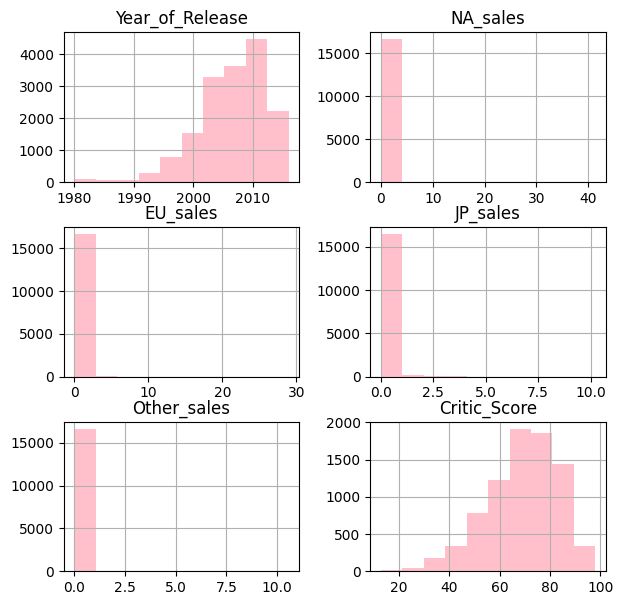

In [2]:
try:
    df = pd.read_csv('/datasets/games.csv')
except:
    df = pd.read_csv('games.csv')
    
display(df.info())
display(df.head())
df.hist(figsize=(7, 7), color='pink')
plt.show();

In [3]:
print('Количество пропусков в датасете')
print(df.isna().sum())
pd.DataFrame(round(df.isna().mean()*100,)).style.background_gradient('coolwarm')

Количество пропусков в датасете
Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64


,0
Name,0.000000
Platform,0.000000
Year_of_Release,2.000000
Genre,0.000000
NA_sales,0.000000
EU_sales,0.000000
JP_sales,0.000000
Other_sales,0.000000
Critic_Score,51.000000
User_Score,40.000000


### Вывод по первому блоку

В таблице 11 столбцов. Типы данных —  float64 и object.

Есть пропуски в признаках: 
- `Name`: 2 (0%)
- `Year_of_Release`: 269 (2%) (необходимо поменять тип данных на *int*)
- `Genre`: 2 (0%)
- `Critic_Score`: 8578 (51%) (необходимо поменять тип данных на *int*, так как шкала оценки 100 не предполагает дробных значений)
- `User_Score`: 6701 (40%)
- `Rating`: 6766 (40%)

## Предобработка данных

Приведем названия стоцов к одному виду:

In [4]:
df.columns = df.columns.str.lower()
df.rename(columns={'rating': 'rating_esrb'}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating_esrb      9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Проверим явные дубликаты

In [5]:
print('Явных дубликатов:', df.duplicated().sum()) 

Явных дубликатов: 0


### Столбец `name`

Проверим игры без названия: 

In [6]:
df[df['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating_esrb
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


В строчка 659 и 14244 есть две игры, одного года выпуска, но при это почти все признаки пустые. Сразу удалим их. 

In [7]:
df.drop([659, 14244],inplace=True)
print('Количество пропусков в датасете:')
df.isna().sum()

Количество пропусков в датасете:


name                  0
platform              0
year_of_release     269
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8576
user_score         6699
rating_esrb        6764
dtype: int64

### Столбец `platform`

Удостоверимся, что в названиях **платформ** нет неявнях дубликатов.

In [8]:
df['platform'].value_counts()

PS2     2161
DS      2151
PS3     1331
Wii     1320
X360    1262
PSP     1209
PS      1197
PC       974
XB       824
GBA      822
GC       556
3DS      520
PSV      430
PS4      392
N64      319
XOne     247
SNES     239
SAT      173
WiiU     147
2600     133
NES       98
GB        98
DC        52
GEN       27
NG        12
WS         6
SCD        6
3DO        3
TG16       2
PCFX       1
GG         1
Name: platform, dtype: int64

С данными все ок.

### Столбец `year_of_release`

Попробуем восстановить данные о **дате релиза**: часто в названии пишут цифры, которые обозначают год выпуска, кроме того игры в спортивных жанрах ('Sports', 'Racing', 'Fighting') обычно выпускают к новому сезону (если написано FIFA 2010, год выпуска будет 2009). <br>

Создадим формулу, которая будет разделять название игры на отдельные слова, последнее из которых будет обозначать год. <br>

Остальные строки удалим, так как анализовать будет невозможно. И приведем тип данных к целому числу, потому что год не может быть дробным.  

In [9]:
def fill_year(row):
    year = 0
    last_word = ''
    genre = row[3]
    for word in row[0].split():
        try:
            last_word = word
            year = int(word)
        except:
            continue
    if genre in ('Sports', 'Racing', 'Fighting'):
        if year > 2000 or last_word in ('2K6','2K8'):
            if genre == 'Sports':
                year -=1
            if last_word == '2K6':
                year = 2005
            elif last_word == '2K8':
                year = 2007
            if year < 2017 and np.isnan(row[2]):
                row[2] = year
    return row

df = df.apply(fill_year, axis=1)
df['year_of_release'].isna().sum()

251

In [10]:
df.drop(df[df['year_of_release'].isna()].index,inplace=True)
df['year_of_release'] = pd.to_numeric(df['year_of_release'], \
                                      downcast='integer')
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating_esrb
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [11]:
df['year_of_release'].isna().sum()

0

### Столбец `user_score`

Заменим значение "tbd"(To Be Determined) в столбце с **оценкой пользователя** на пустоту NaN, так как эти игры еще не успели оценить (игра не вышла / прошлом мало времени с релиза).

In [12]:
df['user_score'] = df['user_score'].replace('tbd', np.nan).astype('float')
print('Кол-во пропусков в столбце `user_score`', df['user_score'].isna().sum()) 

Кол-во пропусков в столбце `user_score` 8989


Заполнить столбцы с **оценками пользователей и критиков** медианой или средним значением нельзя, потому что это субъективная оценка каждоый конкретной игры (года релиза, жанра и тд). Пока оставим, как есть

### Столбец `rating_esrb`

**Рейтинг esrb** (Entertainment Software Rating Board) —  организация, основное направление деятельности — принятие и определение рейтингов для компьютерных видеоигр и другого развлекательного программного обеспечения в США и Канаде. 

Кроме ESRB в мире существуют другие организации по оценке игр: Pan European Game Information (PEGI) – Европа, Unterhaltungssoftware Selbstkontrolle (USK) – Германия, Computer Entertainment Rating Organization (CERO) – Япония и тд. 

Так, рейтинг ESRB больше используется для американских и канадских игр, в наших данных 2/3 игр из других стран, поэтому наличие пропусков объясняется страной выпуска, их иможно заменить на no_info. 

In [13]:
df['rating_esrb'] = df['rating_esrb'].fillna('tbd')

In [14]:
print('Кол-во пропусков в столбце `rating_esrb`', df['rating_esrb'].isna().sum()) 

Кол-во пропусков в столбце `rating_esrb` 0


### Столбцы `critic_score` и `user_score`

Пропуски в `critic_store` и `user_score` можно заполнить нулями: есть вероятность, что игру ещё не оценили (новая), либо не набралось достаточного количества ревью (что тоже информация для анализа). 

In [15]:
df['critic_score'] = df['critic_score'].fillna(0).astype('int')
#df['user_score'] = df['user_score'].fillna(0).astype('float')
print('Кол-во пропусков в столбце `critic_score`', df['critic_score'].isna().sum()) 
print('Кол-во пропусков в столбце `user_score`', df['user_score'].isna().sum()) 

Кол-во пропусков в столбце `critic_score` 0
Кол-во пропусков в столбце `user_score` 8989


### Столбец `all_sales` – new

Посчитаем суммарные продажи во всех регионах и запишите их в отдельный столбец.

In [16]:
df['all_sales'] = df[['na_sales','eu_sales','jp_sales', \
                      'other_sales']].sum(axis = 1)
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating_esrb,all_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,0,NaN,tbd,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,0,NaN,tbd,31.38


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16462 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16462 non-null  object 
 1   platform         16462 non-null  object 
 2   year_of_release  16462 non-null  int16  
 3   genre            16462 non-null  object 
 4   na_sales         16462 non-null  float64
 5   eu_sales         16462 non-null  float64
 6   jp_sales         16462 non-null  float64
 7   other_sales      16462 non-null  float64
 8   critic_score     16462 non-null  int64  
 9   user_score       7473 non-null   float64
 10  rating_esrb      16462 non-null  object 
 11  all_sales        16462 non-null  float64
dtypes: float64(6), int16(1), int64(1), object(4)
memory usage: 1.5+ MB


### Вывод по второму блоку

1. Проведена предобработка данных: 
    * Удалили игры в строчках 659 и 14244 (почти все признаки пустые, скорее всего, дубликат);
    * Привели названия столбцов к нижнему регистру
    * Пропуски обработанны:
        - Пропуски в столбцах с рейтингом от критиков и пользователей  заменили на 0, так как его пока нет (возможно ожидается и зависит от года выхода); 
        - Пропуски в столбце с рейтингом ESRB заменили на *no_info*, так как рейтинг может быть неактуальным для Европы, Японии и др стран, крмое Америки и Канады.
    * Преобразовали данные к нужному типу данных.

2. Данные готовы к анализу. 

## Исследовательский анализ данных

### Анализ количества релизов игр в разные годы

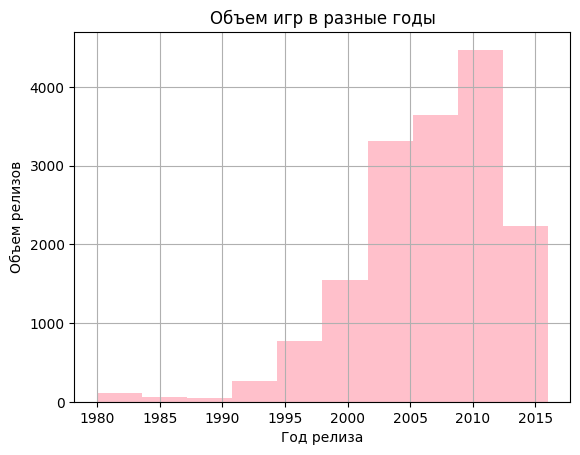

In [18]:
df['year_of_release'].value_counts()
df['year_of_release'].hist(color='pink')

plt.title('Объем игр в разные годы')
plt.xlabel('Год релиза')
plt.ylabel('Объем релизов')

plt.show();

**ВЫВОД:**

С 80-х по 90-е года было выпущено очень мало игр. Технологический прорыв случился после 2000 года, с этого времени резко подскачило количество релизов. 

Пик релизов приходится на 2008-2012 год, после него из-за экономического кризиса рынок компьютерных игр пошел на спад. 

### Анализ продаж по платформам сковзь года

Отберем платформы с наибольшими суммарными продажами и построим распределение по годам. Необходимо выяснить за какой характерный срок появляются новые и исчезают старые платформы.



In [19]:
df_top_platform = df.groupby('platform')['all_sales'].sum().\
sort_values(ascending = False).reset_index()
df_top_platform

,platform,all_sales
0,PS2,1247.53
1,X360,961.30
2,PS3,931.34
3,Wii,891.18
4,DS,802.79
5,PS,727.58
6,PS4,314.14
7,GBA,312.88
8,PSP,289.69
9,3DS,257.81


Составим список ТОП-10 платформ по продажам

In [20]:
top_platform = df_top_platform.loc[:9, 'platform'].values
top_platform


array(['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS', 'PS4', 'GBA', 'PSP',
       '3DS'], dtype=object)

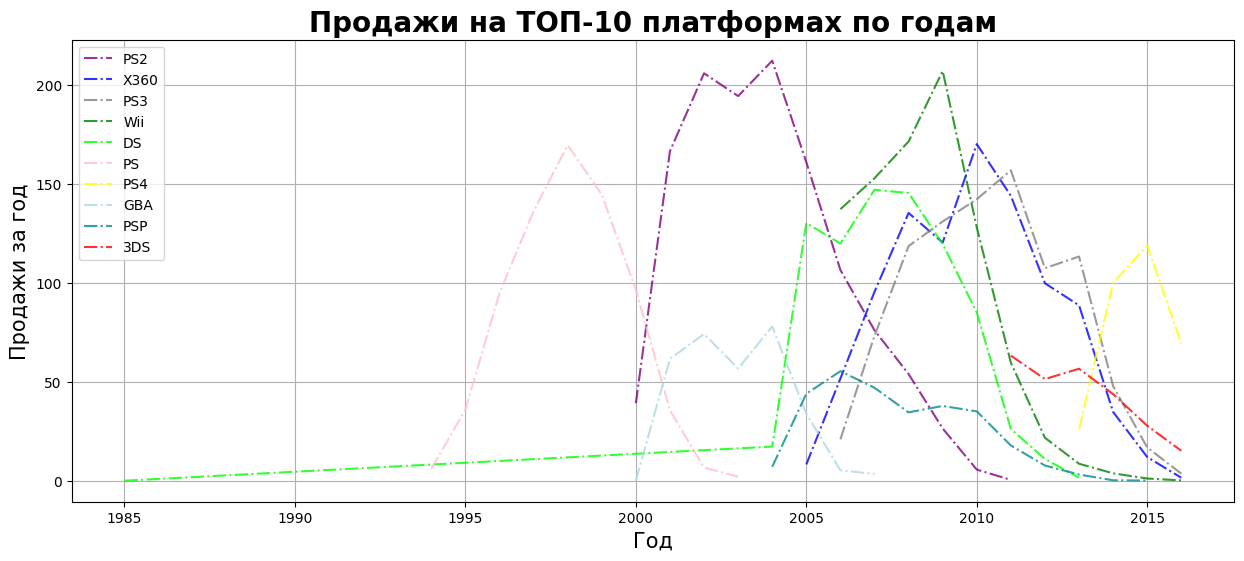

In [21]:
color = ['purple', 'blue','grey','green','lime','pink',\
         'yellow','lightblue','darkcyan','red']

plt.figure(figsize=(15, 6))
plt.grid()
plt.title('Продажи на ТОП-10 платформах по годам', fontsize = 20, fontweight='bold')

mean_living_platform = 0
for i in range(0,len(top_platform)):
    platform  = df.query('platform == @top_platform[@i]').\
    groupby('year_of_release')['all_sales'].sum()
    mean_living_platform += platform.count()
    platform.plot(x=platform.index, y=platform.values, style='-.', \
                  color=color[i], \
                  label=top_platform[i], alpha=0.8, grid=True);
plt.xlabel('Год', fontsize = 15)    
plt.ylabel('Продажи за год', fontsize = 15)
plt.legend()
plt.show();

Ограничим выборку от 1995 года, так как есть большой вброс у платформы DS, которая выпущена в ноябре 2004. А также уберем из выборки новые платформы (с 2013 года). 

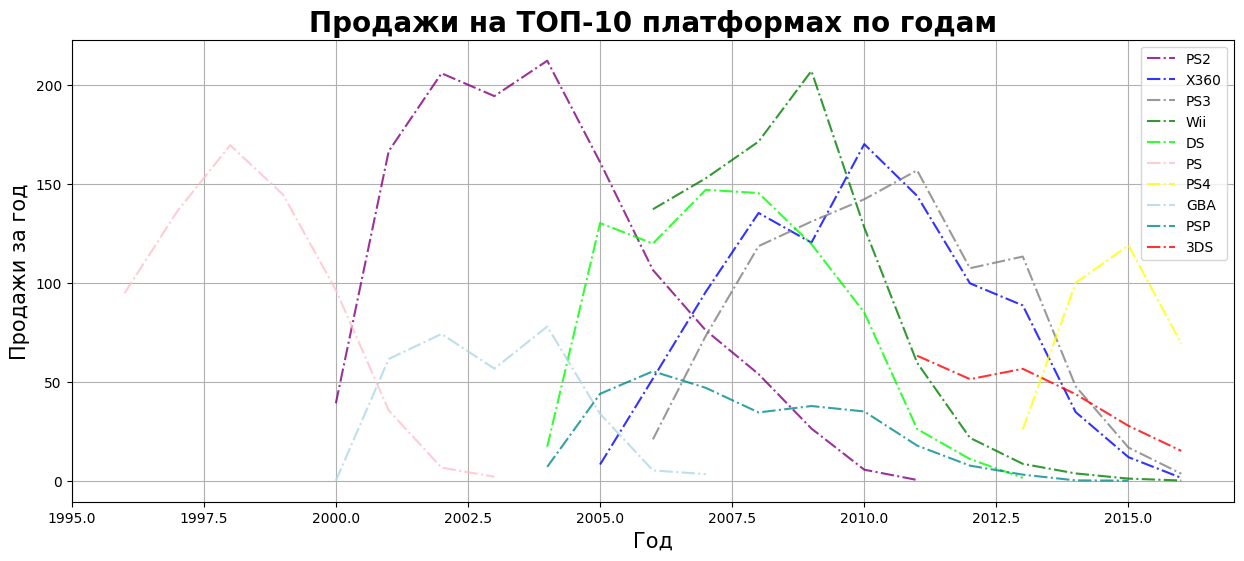

In [22]:
color = ['purple', 'blue','grey','green','lime','pink','yellow', \
         'lightblue','darkcyan','red']

plt.figure(figsize=(15, 6))
plt.grid()
plt.title('Продажи на ТОП-10 платформах по годам', fontsize = 20, fontweight='bold')

mean_living_platform = 0
for i in range(0,len(top_platform)):
    platform  = df.query('platform == @top_platform[@i] and 1995 \
    < year_of_release').groupby('year_of_release')['all_sales'].sum()
    mean_living_platform += platform.count()
    platform.plot(x=platform.index, y=platform.values, style='-.', \
                  color=color[i], \
                  label=top_platform[i], alpha=0.8, grid=True);
plt.xlabel('Год', fontsize = 15)    
plt.ylabel('Продажи за год', fontsize = 15)
plt.legend()
plt.show();

Посчитаем продолжительность существования платформ: 

In [23]:
years_of_life = df.pivot_table(index='platform',values='year_of_release',aggfunc=['min','max'])
years_of_life.columns=['min','max']
years_of_life['years_of_life']=years_of_life['max']-years_of_life['min']
years_of_life

,min,max,years_of_life
platform,,,
2600,1980,1989,9
3DO,1994,1995,1
3DS,2011,2016,5
DC,1998,2008,10
DS,1985,2013,28
GB,1988,2001,13
GBA,2000,2007,7
GC,2001,2007,6
GEN,1990,1994,4


**ВЫВОД:**

В среднем одна платформа пользуется успехом около 9 лет. Можно также отметить, что компания Sony регулярно выпускает новую игровую платформу (PS, PS2, PS3, PS4), а игры для старой версии пользуются популярностью еще примерно 3-5 лет после выпуска новой серии - что стоит учесть в рекламной кампании, а DS (скорее всего это игровая консоль Nintendo DS) является самой долгоживущей. 

Стоит отметить, что после 2010 года наблюдается спад в продажах на всех платформах (что мы подтвердили выше). 

### Анализ данных за актуальный период

Платформы: топ по высоким и низким продажам. Потенциально прибыльные платформы. 

На мой взгляд, актуальный период для аналитики - это продажи с 2012-13 года по 2016. Если мы принимает факт того, что средняя продолжительность существования платформы около 10 лет, как раз все перспективные платформы будут на пике в 2017 году и мы сможем спланировать стратегию продвижения еще на несколько лет вперед. 

Точно стоит сделать акцент на платформе PS4. По предоставленным данным, платформы Sony пользуются успехом, а пик продаж новой версии может случиться как раз на 2017-2018 год.

Мы рассмотрели топ 10 платформ по продажам, однако стоит оценить все платформы с 2013 года, скорее всего там есть перспективные варинаты, которые еще не достигли пика по продажам. Но на них стоит обратить внимание. 

Выберем данные за 2013-2016 год и построим распределение продаж за этот период по всем платформам. 

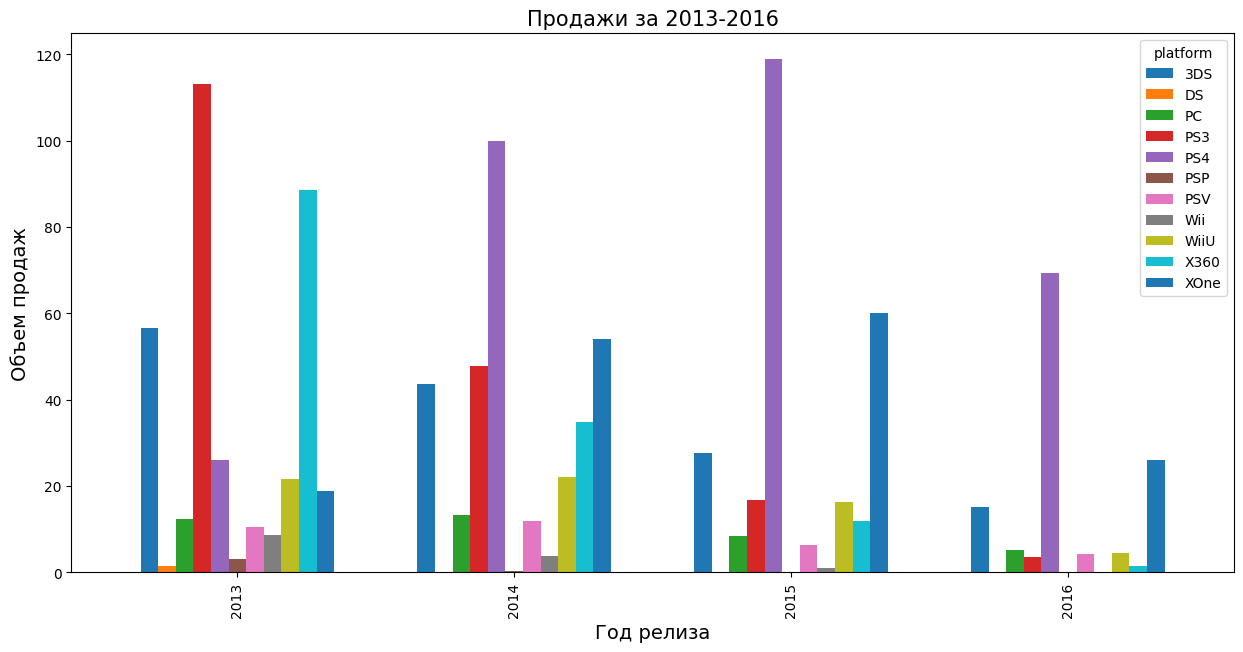

platform,3DS,DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
year_of_release,,,,,,,,,,,
2013,56.57,1.54,12.38,113.25,25.99,3.14,10.59,8.59,21.65,88.58,18.96
2014,43.76,NaN,13.28,47.76,100.00,0.24,11.90,3.75,22.03,34.74,54.07
2015,27.78,NaN,8.52,16.82,118.90,0.12,6.25,1.14,16.35,11.96,60.14
2016,15.14,NaN,5.25,3.60,69.25,NaN,4.25,0.18,4.60,1.52,26.15


In [24]:
actual_df = df.query('year_of_release > 2012')

actual_top_platform = actual_df.pivot_table(index='year_of_release', 
                                      columns = 'platform',
                                      values='all_sales',
                                      aggfunc='sum').query('year_of_release != -1')

actual_top_platform.plot(kind='bar', figsize=(15, 7), width=0.7)
plt.title('Продажи за 2013-2016', fontsize=15)
plt.xlabel('Год релиза', size=14)
plt.ylabel('Объем продаж', size=14)
plt.show()

actual_top_platform

На графике мы видим, что в лидеры выбивается PS4 (что уже было доказано ранее), а также неплохие продажи у XOne.

Продажи старых платформ падают: PS3, DS, PSP, Wii (ему на замену пришел WiiU - может быть перспективной платформой), X360.

Стоит отметить, что даже  на падающих продажах можно заработать, когда объем продаж составляет около 20 млн. копий, как например с 3DS.
        
Кроме того, 30-тилетняя история персональных компьютеров говорит, что игры для PC можно включить в рекомендацию. 

Построим **диаграмму размаха по глобальным продажам игр** в разбивке по платформам.


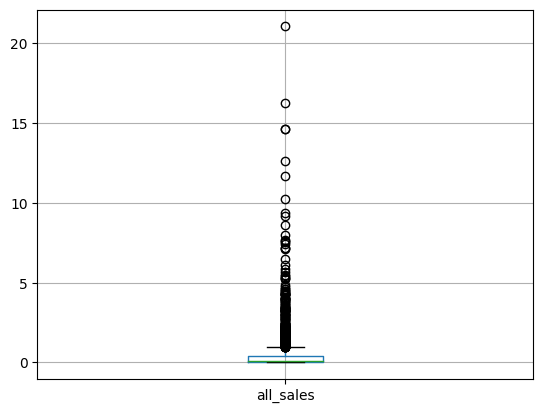

count    2233.000000
mean        0.488442
std         1.235226
min         0.010000
25%         0.030000
50%         0.110000
75%         0.400000
max        21.050000
Name: all_sales, dtype: float64

In [25]:
actual_df.boxplot(column='all_sales')
plt.show()
actual_df['all_sales'].describe()

In [26]:
actual_df.pivot_table(index='platform', values='all_sales', \
                      aggfunc=['sum', 'mean', 'median', 'std', 'count'])\
.sort_values(('median', 'all_sales'), ascending=False)


,sum,mean,median,std,count
,all_sales,all_sales,all_sales,all_sales,all_sales
platform,,,,,
X360,136.80,0.735484,0.265,1.663275,186
XOne,159.32,0.645020,0.220,1.036139,247
PS4,314.14,0.801378,0.200,1.609456,392
WiiU,64.63,0.562000,0.200,1.038778,115
Wii,13.66,0.593913,0.180,0.915432,23
DS,1.54,0.192500,0.150,0.172026,8
PS3,181.43,0.525884,0.150,1.451939,345
3DS,143.25,0.472772,0.090,1.381347,303


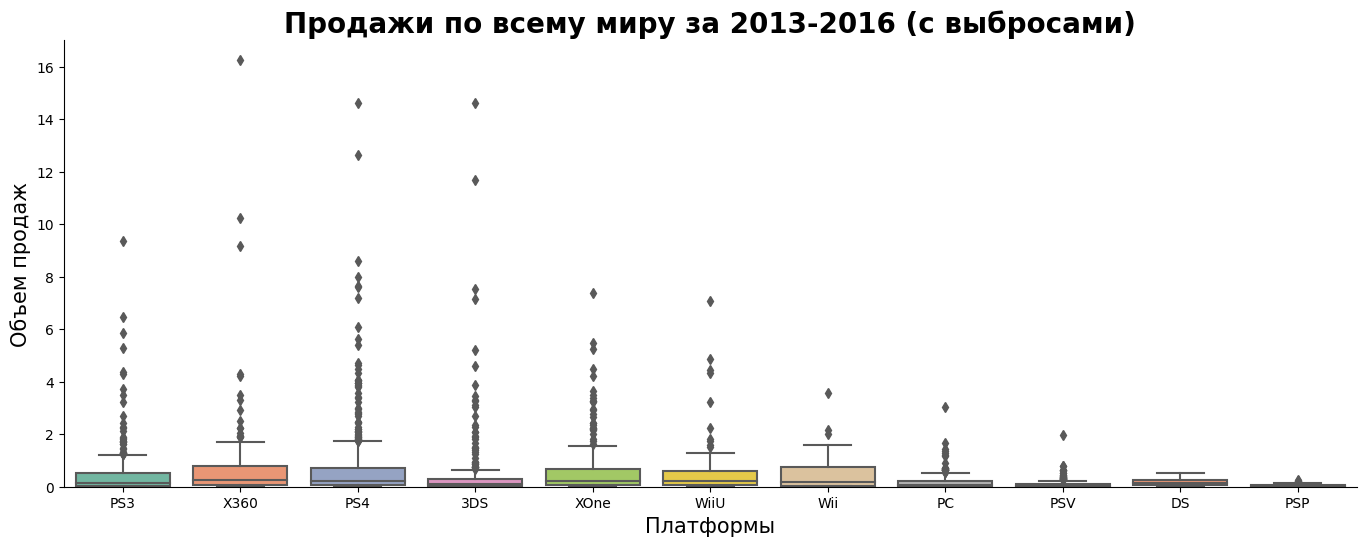

In [27]:
sns.catplot(kind='box', data=actual_df, x='platform', y='all_sales', \
            height=5, aspect=2.7,  palette='Set2')
plt.xlabel('Платформы', size=15)
plt.ylabel('Объем продаж', size=15)
plt.ylim(0,17)
plt.title('Продажи по всему миру за 2013-2016 (с выбросами)', fontsize=20, fontweight='bold')
plt.show()

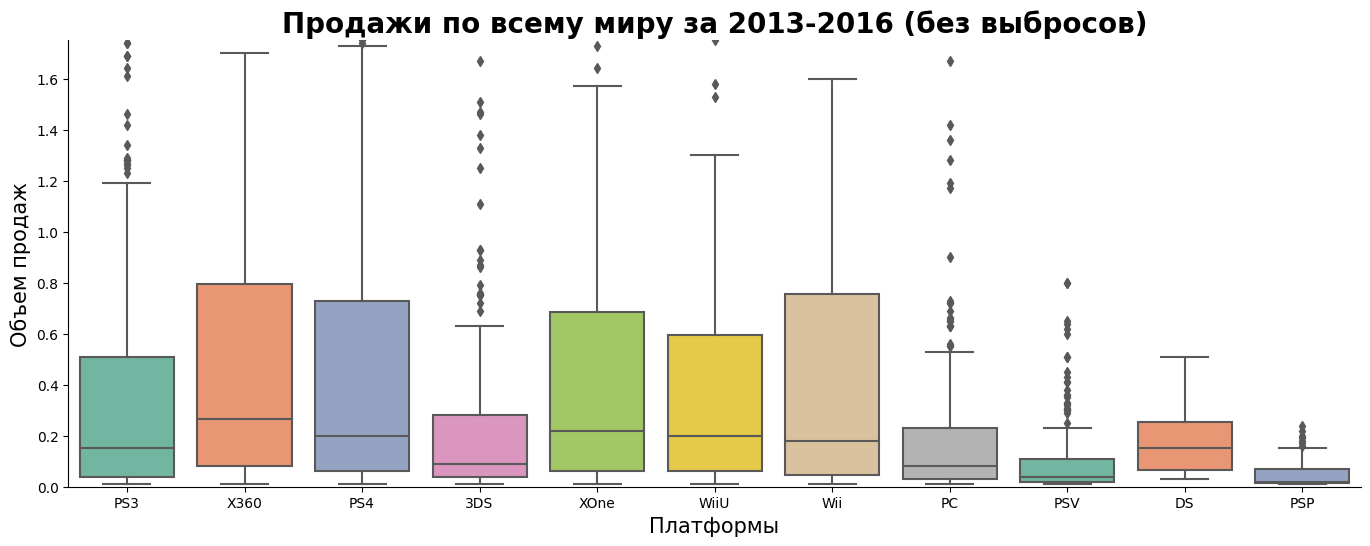

In [28]:
sns.catplot(kind='box', data=actual_df, x='platform', y='all_sales', \
            height=5, aspect=2.7,palette='Set2')
plt.xlabel('Платформы', size=15)
plt.ylabel('Объем продаж', size=15)
plt.ylim(0,1.75)
plt.title('Продажи по всему миру за 2013-2016 (без выбросов)', fontsize=20, fontweight='bold')
plt.show()

У платформ **X360, PS4, XOne, WiiU, Wii** большие боксы, медианы на уровне 0,2-0,3 млн продаж. Однако стоит упомянуть факт того, что платформы X360 и Wii заканчивают цикл существования на рынке, поэтому не стоит делать акцент на этих платформах, особенно на Wii, у которой почти нет бестселлеров. Можно рассмотреть платформу нового поколения **WiiU**, продажи которой еще не очень высокие из-за недолго существования на рынке и довольно успешной истории платформы предыдущего поколения Wii. 

Лидер продаж по миру за 2013-2016 года - платформа **PS4**, у этой платформы самый большой и стабильный размах, больше выбросов (от 2 до 15 млн продаж), а значит больше игр-бестселлеров, которые приносят большую прибыль.

Платформа **3DS** относительно новая, у нее маленький ящик по сравненению с топовыми платформами, но есть весьма много выбросов. А значит, что основная часть дохода платформы - это одиночные игры-бестселлеры. На нее можно поставить ставку, так как благодаря хорошо продающимся играм и началу цикла существования платформы платформа перспективна. 

У **XOne** большой бокс, меньше выбросов, а значит люди покупают разные игры, не только популярные. Так как платформа нового поколения, ее можно считать перспективной. 

У **PSP** очень низкие показатели, медиана меньше 0,1 млн. копий, верхняя граница 0,2 млн. На такую платформу точно расчитывать не стоит. 

**На мой взгляд, самые перспективные платформы: PS4, XOne, WiiU и 3DS.**



### Анализ влияния отзывов пользователей и критиков внутри одной популярной платформы
Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами.

,all_sales,critic_score,user_score
all_sales,1.000000,0.227550,-0.031957
critic_score,0.227550,1.000000,0.388245
user_score,-0.031957,0.388245,1.000000


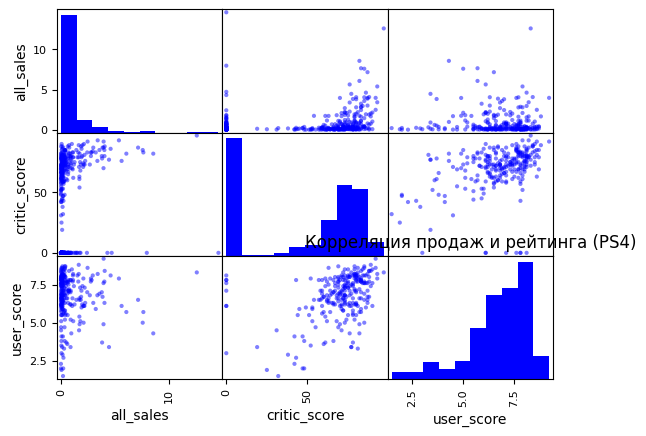

In [29]:
ps4_actual = actual_df.query('platform == "PS4"')
ps4_critic_user_sales = ps4_actual.loc[:, ['all_sales', 'critic_score', 'user_score']]
display(ps4_critic_user_sales.corr())

pd.plotting.scatter_matrix(ps4_critic_user_sales, color='blue', hist_kwds={'color':'blue'})
plt.title('Корреляция продаж и рейтинга (PS4)')
plt.show()

,all_sales,critic_score,user_score
all_sales,1.000000,0.061113,0.241504
critic_score,0.061113,1.000000,0.548960
user_score,0.241504,0.548960,1.000000


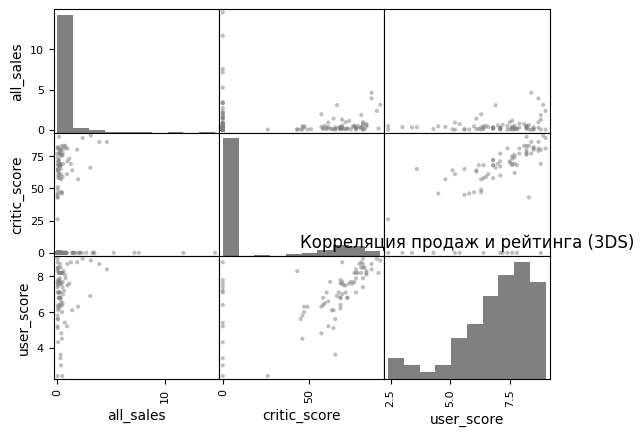

In [30]:
ds3_actual = actual_df.query('platform == "3DS"')
ds3_critic_user_sales = ds3_actual.loc[:,['all_sales', \
                                        'critic_score', 'user_score']]
display(ds3_critic_user_sales.corr())

pd.plotting.scatter_matrix(ds3_critic_user_sales, color='gray', hist_kwds={'color':'gray'})
plt.title('Корреляция продаж и рейтинга (3DS)')

plt.show()



,all_sales,critic_score,user_score
all_sales,1.000000,0.274839,-0.068925
critic_score,0.274839,1.000000,0.249320
user_score,-0.068925,0.249320,1.000000


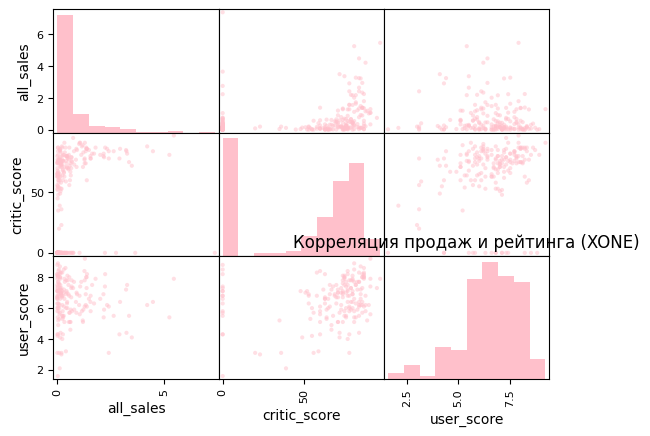

In [31]:
xone_actual = actual_df.query('platform == "XOne"')
xone_critic_user_sales = xone_actual.loc[:,['all_sales', \
                                        'critic_score', 'user_score']]
display(xone_critic_user_sales.corr())

pd.plotting.scatter_matrix(xone_critic_user_sales, \
                           color='pink', hist_kwds={'color':'pink'})
plt.title('Корреляция продаж и рейтинга (XONE)')
plt.show()

По шкале Чеддока корреляция между рейтингом и продажами слабая, значит продажи не так сильно зависят от рейтинга. 

**ВЫВОД:**

1. Есть слабая корреляция между оценками и продажами.
2. Рейтинг пользователей и критиков не влияет на продажи платформ. 

### Распределение игр по жанрам
Самые прибыльные жанры. Жанры с высокими и низкими продажами.

,all_sales
genre,
Action,321.87
Shooter,232.98
Sports,150.65
Role-Playing,145.89
Misc,62.82
Platform,42.63
Racing,39.89
Fighting,35.31
Adventure,23.64


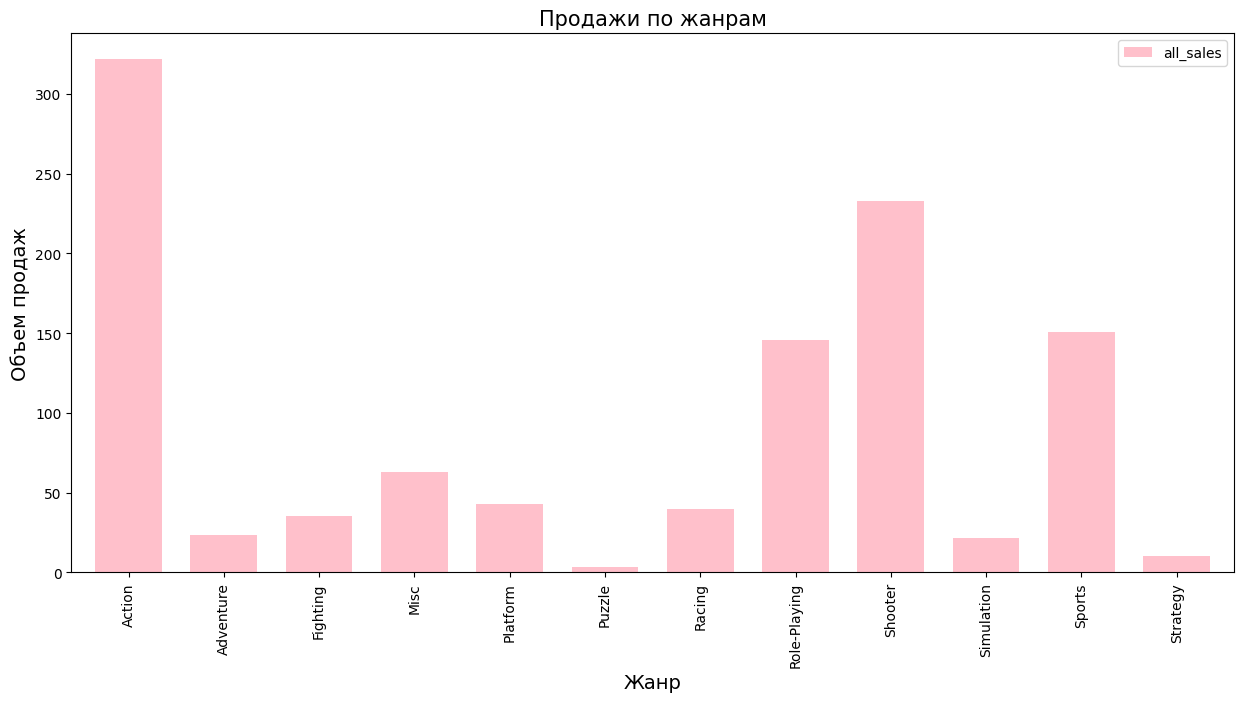

In [32]:
genre_sales = pd.pivot_table(actual_df, index='genre', values='all_sales', aggfunc='sum')
display(genre_sales.sort_values('all_sales', ascending=False))

genre_sales.plot(kind='bar', figsize=(15, 7), width=0.7, color='pink')
plt.title('Продажи по жанрам', fontsize=15)
plt.xlabel('Жанр', size=14)
plt.ylabel('Объем продаж', size=14)
plt.show()

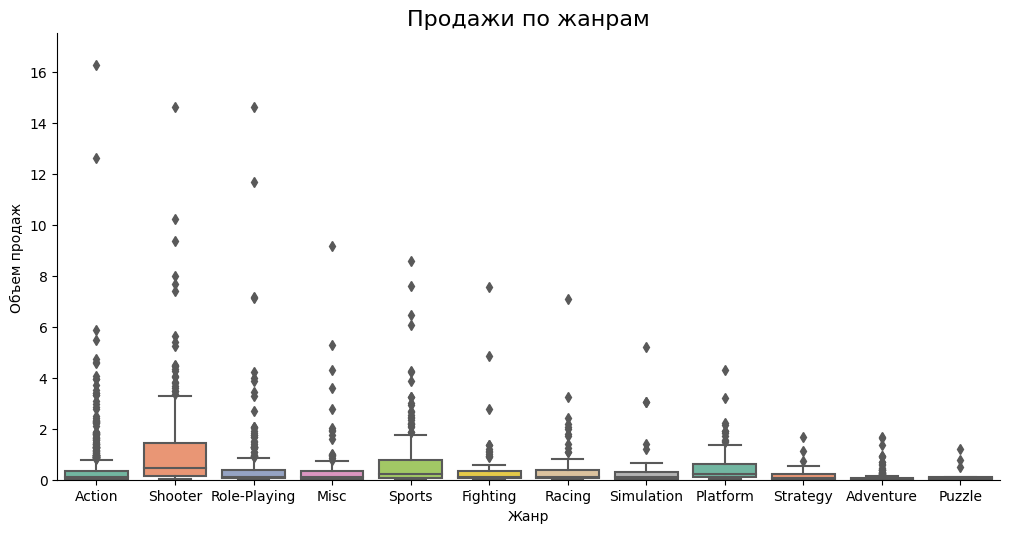

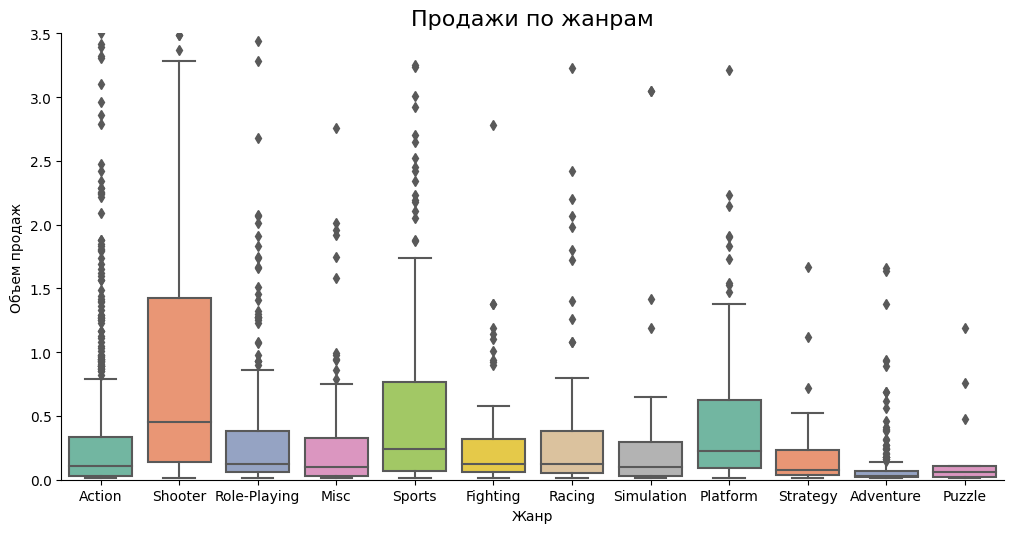

In [33]:
sns.catplot(kind='box', data=actual_df, x='genre', y='all_sales', \
            height=5, aspect=2,palette='Set2')
plt.xlabel('Жанр', size=10)
plt.ylabel('Объем продаж', size=10)
plt.ylim(0,17.5)
plt.title('Продажи по жанрам', fontsize=16)
plt.show()

sns.catplot(kind='box', data=actual_df, x='genre', y='all_sales', \
            height=5, aspect=2,palette='Set2')
plt.xlabel('Жанр', size=10)
plt.ylabel('Объем продаж', size=10)
plt.ylim(0,3.5)
plt.title('Продажи по жанрам', fontsize=16)
plt.show()

**ВЫВОД:**

По объему продаж в четверке лидеров жанров по продажам: экшн (action), шутеры (shooter), спортивные (sports) и ролевая игра (role-playing). 

Однако стоит обратить внимание, что шутеры и спортивные игры имеют более стабльные продажи, чем экшн и компьютерные ролевые игры.  

## Портрет пользователя каждого региона

Определим для пользователя каждого региона (NA, EU, JP):
1. Самые популярные платформы. Различия в долях продаж.
2. Самые популярные жанры. Разница.
3. Влияет ли рейтинг ESRB на продажи в отдельном регионе.

Напишем функцию для построения графиков, описывающих пользователей (соотношение продаж от платформы, жанра и рейтинга ESRB):

In [34]:
def graph_platform (df, year, region, name, axes):
    
    df = df.query('year_of_release >= @year')
    
    sales = df.pivot_table(index='platform', 
                           values=region, 
                           aggfunc='sum').nlargest(5, region)
    
    sales = sales.reset_index()
    
    sales = (
            sales.append({'platform': 'Other', region: df[region].sum() 
                       - sales[region].sum()}, ignore_index= True)
         )
    
    
    sales.columns = ['platform', 'sales']
    sales.plot(kind='pie',
               y="sales",
               cmap='spring',
               autopct='%1.0f%%',
               wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
               textprops={'size': 'x-large'}, labels = sales.platform,
               legend=False, 
               title = f"Популярность платформ в {name} ", 
               ax = axes).set(ylabel='')
    plt.tight_layout()

In [35]:
def graph_genre (df, year, region, name, axes):
    
    df = df.query('year_of_release >= @year')
    
    sales = df.pivot_table(index='genre', 
                           values=region, 
                           aggfunc='sum').nlargest(5, region)
    
    sales = sales.reset_index()
    
    sales = (
            sales.append({'genre': 'Other', region: df[region].sum() 
                       - sales[region].sum()}, ignore_index= True)
         )

    sales.columns = ['genre', 'sales']
    sales.plot(kind='pie',
               y="sales",
               cmap='summer',
               autopct='%1.0f%%',
               wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
               textprops={'size': 'x-large'}, labels = sales.genre,
               legend=False, 
               title = f"Популярность жанров в {name} ", 
               ax = axes).set(ylabel='')
    plt.tight_layout()

### Обзор рынка за 2013 год

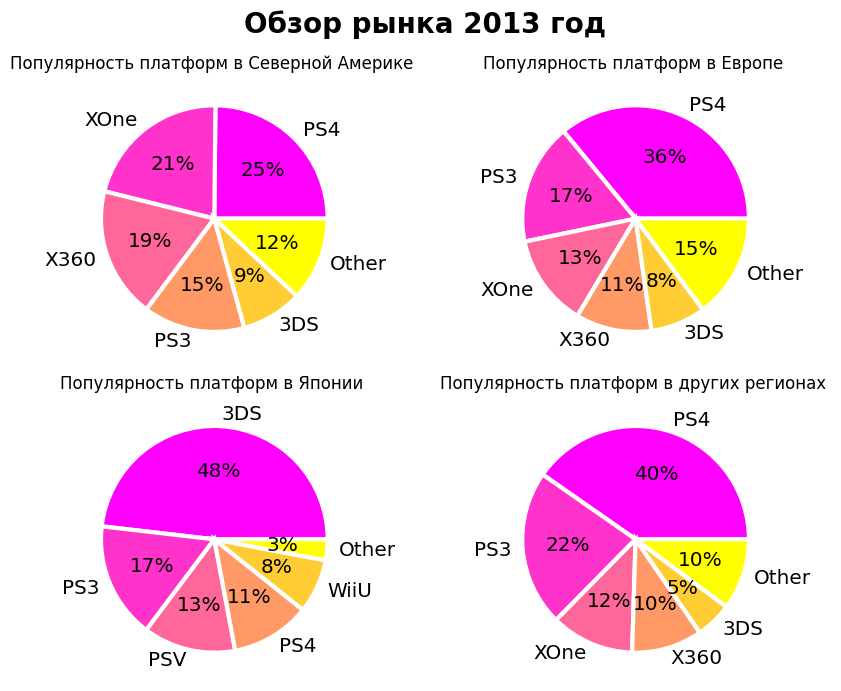

In [36]:
fig, axes = plt.subplots(2, 2, figsize = (10,7))
fig.suptitle('Обзор рынка 2013 год', fontsize = 20, fontweight='bold')

x_year = 2013

graph_platform(df, x_year, 'na_sales', 'Северной Америке', axes[0, 0])
graph_platform(df, x_year,'eu_sales', 'Европе', axes[0, 1])
graph_platform(df, x_year, 'jp_sales', 'Японии', axes[1, 0])
graph_platform(df, x_year, 'other_sales', 'других регионах', axes[1, 1])

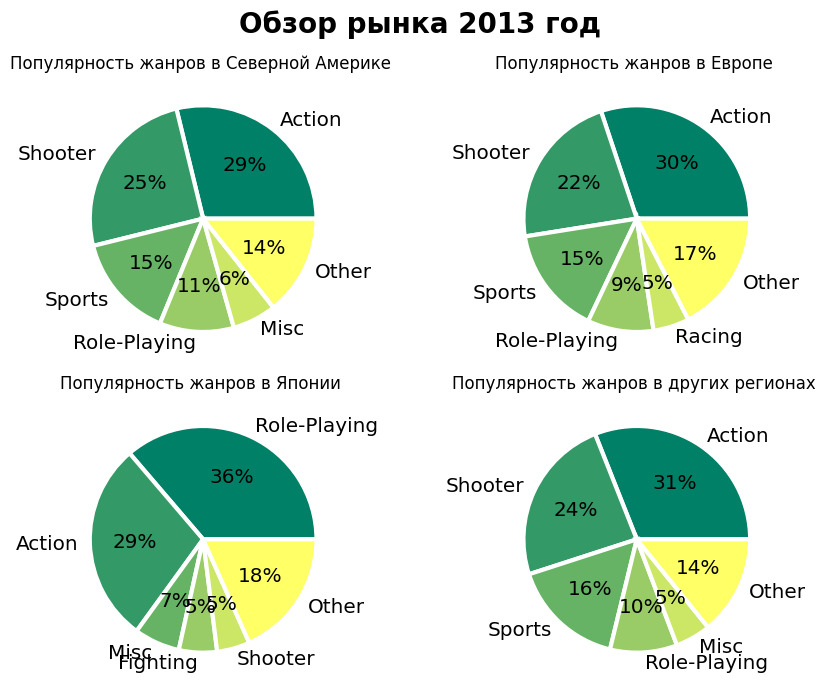

In [37]:
fig, axes = plt.subplots(2, 2, figsize = (10,7))
fig.suptitle('Обзор рынка 2013 год', fontsize = 20, fontweight='bold')

x_year = 2013

graph_genre(df, x_year, 'na_sales', 'Северной Америке', axes[0, 0])
graph_genre(df, x_year,'eu_sales', 'Европе', axes[0, 1])
graph_genre(df, x_year, 'jp_sales', 'Японии', axes[1, 0])
graph_genre(df, x_year, 'other_sales', 'других регионах', axes[1, 1])

#### Вывод

Данные показали, что Япония выделяется на фоне всего мира: самой популярной платформой во всем мире, кроме Японии, является является игровая приставка Sony нового поколения, PS4. Также в топе: XOne, X360, PS3 и 3DS.
В Японии большая часть игроков предпочитает портативные консоли, самая популярная из которых Nintendo 3DS. Менее популярны игровые приставки PS3 и PS4, портативная консоль PlayStation Vita.

Во всем мире, кроме Японии, предпочитают экшн-жанры, шутеры и спортивные игры. В Японии любят играть в менее жестокие игры, такие как компьютерные ролевые игры и экшн. Шутеры и борьба занимают последние места в топах. 

### Обзор рынка за 2014 год

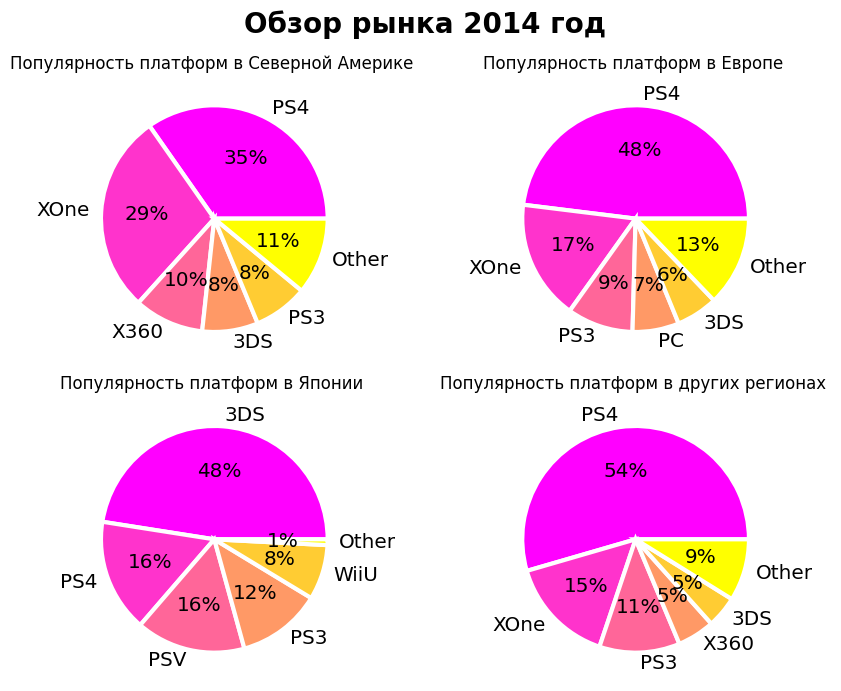

In [38]:
fig, axes = plt.subplots(2, 2, figsize = (10,7))
fig.suptitle('Обзор рынка 2014 год', fontsize = 20, fontweight='bold')

x_year = 2014

graph_platform(df, x_year, 'na_sales', 'Северной Америке', axes[0, 0])
graph_platform(df, x_year,'eu_sales', 'Европе', axes[0, 1])
graph_platform(df, x_year, 'jp_sales', 'Японии', axes[1, 0])
graph_platform(df, x_year, 'other_sales', 'других регионах', axes[1, 1])

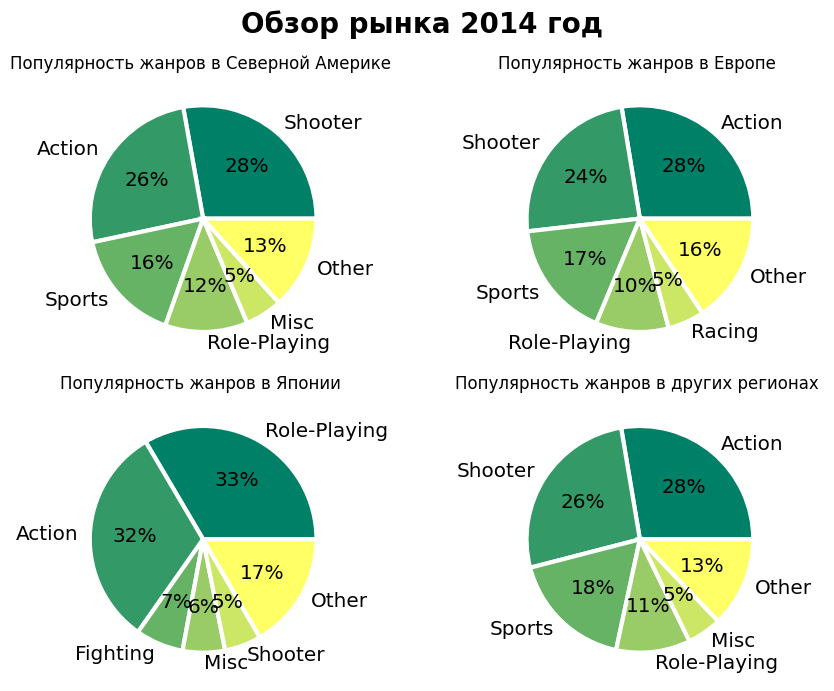

In [39]:
fig, axes = plt.subplots(2, 2, figsize = (10,7))
fig.suptitle('Обзор рынка 2014 год', fontsize = 20, fontweight='bold')

x_year = 2014

graph_genre(df, x_year, 'na_sales', 'Северной Америке', axes[0, 0])
graph_genre(df, x_year,'eu_sales', 'Европе', axes[0, 1])
graph_genre(df, x_year, 'jp_sales', 'Японии', axes[1, 0])
graph_genre(df, x_year, 'other_sales', 'других регионах', axes[1, 1])

#### Вывод

В 2014 году тенденция по популярности платформ не изменилась, в мире всё так же самой популярной платформой остается PS4, в Японии – 3DS

В области жанров наблюдается небольшое увеличение популярности экшн-игр (во всём мире, включая Японию) и спортивных игр, тем временем шутеры теряют позиции, но незначительно. 

### Обзор рынка за 2015 год

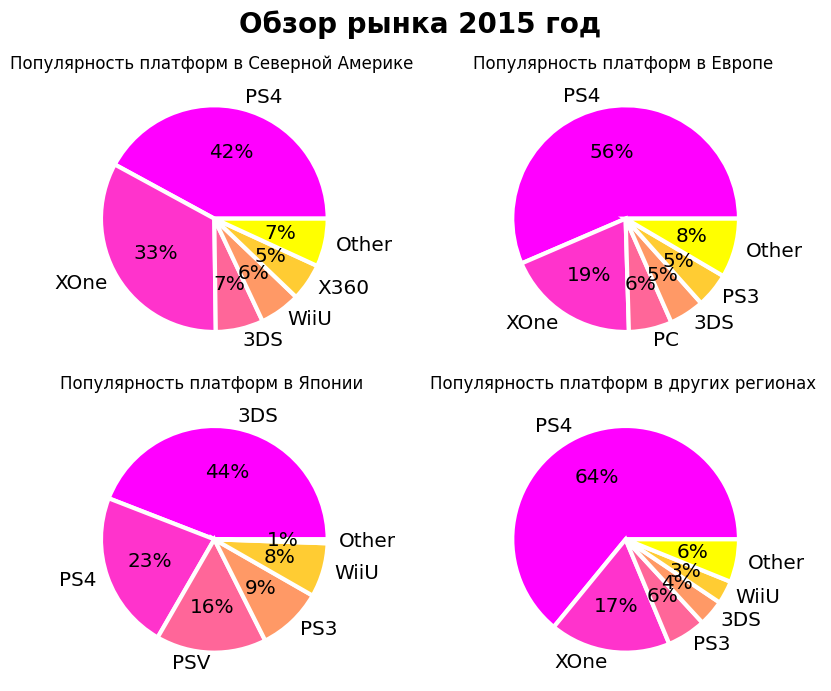

In [40]:
fig, axes = plt.subplots(2, 2, figsize = (10,7))
fig.suptitle('Обзор рынка 2015 год', fontsize = 20, fontweight='bold')

x_year = 2015

graph_platform(df, x_year, 'na_sales', 'Северной Америке', axes[0, 0])
graph_platform(df, x_year,'eu_sales', 'Европе', axes[0, 1])
graph_platform(df, x_year, 'jp_sales', 'Японии', axes[1, 0])
graph_platform(df, x_year, 'other_sales', 'других регионах', axes[1, 1])

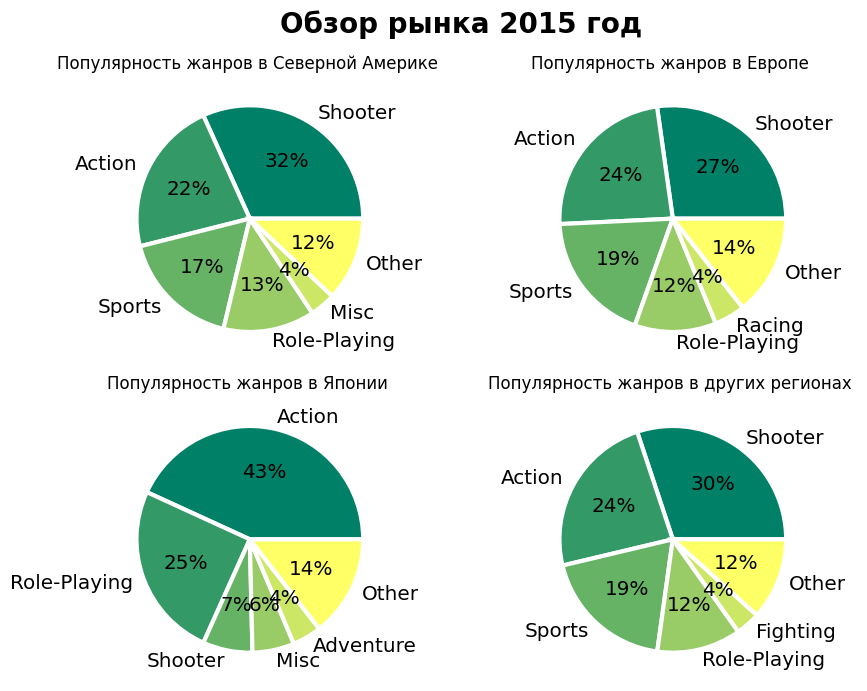

In [41]:
fig, axes = plt.subplots(2, 2, figsize = (10,7))
fig.suptitle('Обзор рынка 2015 год', fontsize = 20, fontweight='bold')

x_year = 2015

graph_genre(df, x_year, 'na_sales', 'Северной Америке', axes[0, 0])
graph_genre(df, x_year,'eu_sales', 'Европе', axes[0, 1])
graph_genre(df, x_year, 'jp_sales', 'Японии', axes[1, 0])
graph_genre(df, x_year, 'other_sales', 'других регионах', axes[1, 1])

В 2015 году в Европе популярность PS4 выросла на весомые 8%, во всём мире, включая Японию тоже виден рост популярности платформы: в Северной Америке +7%, в Японии +6% и в других регионах +10%.

XOne в Северной Америке и Европе тоже набрали небольшой прирост популярности, а в других регионах наоборот – популярность упала. 

Интерес к самой популярной платформе 2013 и 2014 годов в Японии – 3DS, тоже снизилась на 4%, в 2015 году японские игроки стали больше интересоваться PS4. Однако в стране почти половина игроков всё ещё пользуется 3DS.

Самым популярным жанром в 2015 году стал шутер. Несмотря на небольшой прирост популярности жанра в Японии, игроки страны остались любителями экшн-игр (популярность увеличилась на 10%), а ролевые игры стремительно отходят на второй план. 

### Распределение рейтинга ESRB

Рейтинг ESRB:
1. «EC» («Early childhood») — «Для детей младшего возраста» - 3+
Для детей 3+, обычно развивающие игры

2. «E» («Everyone») — «Для всех» - 6+
Подходит всем 6+. Игры содержат минимум насилия. (Изначально была "K-A" ("Kids to Adults"))

3. «E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше» 10+
Игры могут содержать больше мультипликационного насилия, откровенные сцены или минимальное количество крови. 

4. «T» («Teen») — «Подросткам» - 13+
Проекты из данной категории могут содержать насилие, непристойные сцены, грубый юмор, откровенное сексуальное содержимое, кровь или нечастое использование ненормативной лексики.

5. «M» («Mature») — «Для взрослых» - 17+
Игры могут содержать жестокое насилие, большое количество крови с расчленением, непристойные сексуальные сцены или грубую ненормативную лексику, нежелательную для младшей аудитории.

6. «AO» («Adults Only 18+») — «Только для взрослых» - 18+
Проекты могут содержать длительные сцены жестокого насилия и/или откровенное сексуальное содержимое, а также сцены с обнажением. 

7. «RP» («Rating Pending») — «Рейтинг ожидается»
Используется только на рекламных презентациях и в демо-версиях игр до официальной даты выпуска в продажу

In [42]:
row = ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']
esrb = pd.pivot_table(df, index='rating_esrb', \
                      values=row,
                      aggfunc='sum').sort_values(by=row, ascending=False)
esrb

,eu_sales,jp_sales,na_sales,other_sales
rating_esrb,,,,
E,707.47,198.01,1281.49,233.11
tbd,610.72,836.78,1227.42,150.29
T,421.79,150.70,747.60,152.99
M,480.00,63.58,742.89,176.06
E10+,183.35,40.20,345.51,71.93
K-A,0.27,1.46,2.56,0.03
EC,0.11,0.00,1.53,0.11
AO,0.61,0.00,1.26,0.09
RP,0.03,0.00,0.00,0.01


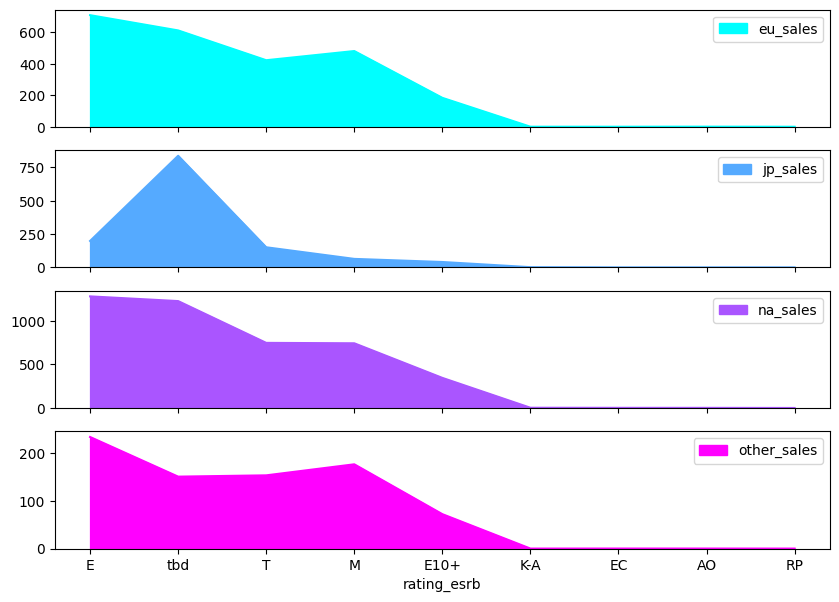

In [43]:
axs = esrb.plot.area(figsize=(10, 7), subplots=True, colormap='cool')


#### Вывод

Во всём мире лучше продаются игры с рейтингом E (для всех), однако стоит отметить, что в данных очень много пропусков в этом признаке. Вероятно новым играм ещё не успели присвоить категорию, либо игроки не обращают на него внимания. Так, в Японии рейтинг ESRB почти не влияет на продажи, так как у большей части игр рейтинга нет (что в целом логично, так как в стране есть своя система оценок).

Также в топе категории игр «T» («Teen») и «M» («Mature»). 

### Вывод по четвертому блоку

Таким образом, можно сделать вывод, что рынок по миру имеет много общего, однако сильно выбивается портрет японского игрока. 

В основном преобладают игроки, которые предпочитают жестокие игры в жанре экшн и шутеры. По большей части в такие игры удобнее играть на игровых приставках, а не на портативных консолях, отсюда и результат, что самой популярной платформой стала приставка Sony нового поколения - PS4.

В Японии рынок отличается: здесь играют на портативных игровых приставках. Этот вариант более удобный для подростка и не требует больших финансовых вложений. Возраст типичного игрока объясняет и выбор жанров: компьютерные ролевые игры часто выпускают с рейтингом 13+ и доступны для подростков.  

## Проверка гипотез

### Гипотеза №1

**Гипотеза №1: средние пользовательские рейтинги платформ Xbox One и PC одинаковые.**

H_0: Пользовательский рейтинг (user_score) Xbox One = пользовательский рейтинг (user_score) PC <br>
H_a: Пользовательский рейтинг (user_score) Xbox One ≠ пользовательский рейтинг (user_score) PC <br>
alpha = 0.05

Составим 2 независимые выборки:

Применим тест Стюдента для проверки гипотезы.

In [44]:
actual_df = actual_df.dropna(subset=['user_score'])
xone_df = actual_df.query('platform == "XOne"')['user_score']
pc_df = actual_df.query('platform == "PC"')['user_score']

In [45]:
alpha = .05 #уровень значимости

results = st.ttest_ind(xone_df, pc_df, nan_policy='omit')

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.14012658403611647
Не получилось отвергнуть нулевую гипотезу


#### Вывод по первой гипотезе

На основании данных, на уровне значимости 5% нет оснований отвергнуть нулевую гипотезу в пользу альтернативы. Полученное значение p-value говорит о том, что хотя оценки игроков на двух платформах и неодинаковы , с вероятностью 14% **такое или большее различие можно получить случайно**. Это слишком большая вероятность, чтобы делать вывод о значимом различии между средними оценками пользователей двух платформ. 

Однако на основании эксперементальных данных мы не можем с точностью подтвердить или опровергнуть гипотезу.

### Гипотеза №2

**Гипотеза №2: Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.**

H_0: Пользовательский рейтинг жанра экшн (Action) = пользовательский рейтинг жанра спорт (Sports) <br>
H_a: Пользовательский рейтинг жанра экшн (Action) ≠ пользовательский рейтинг жанра спорт (Sports)<br>
alpha = 0.05

In [46]:
action_df = actual_df.query('genre == "Action"')['user_score']
sports_df = actual_df.query('genre == "Sports"')['user_score']

In [49]:
results_1 = st.ttest_ind(
    action_df, 
    sports_df, equal_var = False)

print('p-значение:', results_1.pvalue)

if (results_1.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 1.4460039700704315e-20
Отвергаем нулевую гипотезу


#### Вывод по второй гипотезе

**ВЫВОД:** 
P-value стремится к нулю, поэтому вероятность того, что нулевая гипотеза верна тоже около 0%. Отвергаем нулевую гипотезу, скорее всего пользовательский рейтинг жанра экшн (Action) не равен пользовательскому рейтингу жанра спорт (Sports). 

Однако на основании эксперементальных данных мы не можем с точностью подтвердить или опровергнуть гипотезу.

## Общий вывод

В процессе работы былы выполнены: 

1. Обзор данных;


2. Предобработка данных: приведение данных к общему виду, проработка аномальных значений, заполнение пропусков, работа с дубликатами, добавление новых столбцов; 

3. Исследовательский анализ данных:
    - анализ количества релизов игр в разные годы;
    С 80-х по 90-е года было выпущено очень мало игр. Пик релизов приходится на 2008-1912 год, после него из-за экономического кризиса рынок компьютерных игр пошел на спад.
    - анализ продаж по платформам сковзь года;
    В среднем одна платформа пользуется успехом около 10 лет. Sony регулярно выпускает новую игровую платформу (PS, PS2, PS3, PS4), а игры для старой версии пользуются популярностью еще примерно 3-5 лет после выпуска новой серии - что стоит учесть в рекламной кампании, а DS (скорее всего это игровая консоль Nintendo DS) является самой долгоживущей.
    - анализ данных за актуальный период;
    Лидеры продаж и самые перспективные платформы: PS4, 3DS и XOne. 
    - анализ влияния отзывов пользователей и критиков внутри одной популярной платформы;
    Есть средняя корреляция между оценками критиков и продажами, однако оценки всё равно не являются главным критерием продаж. Рейтинг пользователей не влияет на продажи платформ. Оценки критиков влияют на оценки пользователей: чем выше оценка первых, тем высший балл ставят вторые.
    - распределение игр по жанрам;
    В четверке лидеров жанров по продажам: экшн (action), шутеры (shooter), спортивные (sports) и ролевая игра (role-playing).


4. Составлен портрет пользователя каждого региона; <br>

Рынок по миру имеет много общего, однако сильно выбивается портрет японского игрока.

В основном преобладают игроки, которые предпочитают жестокие игры в жанре экшн и шутеры. По большей части в такие игры удобнее играть на игровых приставках, а не на портативных консолях, отсюда и результат, что самой популярной платформой стала приставка Sony нового поколения - PS4.

В Японии рынок отличается: здесь играют на портативных игровых приставках. Этот вариант более удобный для подростка и не требует больших финансовых вложений. Возраст типичного игрока объясняет и выбор жанров: компьютерные ролевые игры часто выпускают с рейтингом 13+ и доступны для подростков.

5. Проведена проверка гипотез. <br>
Гипотеза №1 - подтверждена: вероятность того, что средние значимости рейтинги платформ Xbox One и PC одинаковые равна 14%, что выходит за пределы статистического уровня важности. <br>
Гипотеза №2 - опровергнута: cредние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») равны с вероятностью 0%. 
